# Keras Autoencoder with Annoy for CBIR

## Grayscale 64x128 pixels, 8x16x128 encoder convolutions, GlobalAverage to 128 dimensions

#### Results: Grayscale, even at this resolution seems MUCH better than Black and White (pure through resize or not) or Edge Detection. Unexpected.  But MUCH better at grouping pills through rotations to one another. 


From Annoy: - see below:
0 errors on the 12 image test set.

With full 8100 set of rotated training images, able to map to the set of 180 unrotated images, with only 12 total errors on top 1 evalation.

In [1]:
import fastai
keras.__version__

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.2'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5304298377249610496
]


In [3]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]

In [4]:
from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

# Train model

## Training variables

In [75]:

#target_image_size = (64,112)
#target_image_size = (32,64)
target_image_size = (64,128)

color_mode='grayscale' # 'grayscale' or 'rgb'

if color_mode=='grayscale':
    target_image_size_3D = (target_image_size[0], target_image_size[1], 1)
else: #then rgb
    target_image_size_3D = (target_image_size[0], target_image_size[1], 3)

batch_size_training = 32
batch_size_validation = 32

# Directories
image_dir_base = 'data_with_rotations'
image_dir_training = image_dir_base + '/train'
image_dir_validation = image_dir_base + '/validate'
image_dir_testing = image_dir_base + '/test'
image_dir_samples = image_dir_testing

# Training variables
training_steps_per_epoch = 200
training_number_of_epoch = 5
validation_steps = 200
training_early_stop_patience = 5

# Model name to save
model_name='autoencoder_v2.0_64x128-8x16x128'

# Model name to load for Testing
model_name_pretrained = model_name

# Encoder model name
model_name_encoder = model_name + '-encoder'

In [7]:
# Import required items for training
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import callbacks
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


from sklearn.metrics import label_ranking_average_precision_score
import time

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## Convenience functions

In [8]:
# Unfortunately, matplotlib, cv2, etc only print in greyscale 
#   when you have 3 color axes (RGB) all set to make the image look grey.
#   But Keras loads greyscale images with only a single number (to optimize training, etc)
#   So, we need to convert any Keras greyscale images to have 3 values

def display_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        plt.imshow(single_image)
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        plt.imshow(si)
        
def get_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        return single_image
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        return si
    

## ImageDataGenerators 

In [9]:
# Created the Train and Validation image generators

# Load the data (in that case MNIST)
train_datagen = ImageDataGenerator(
        #shear_range=0.05,
        #zoom_range=0.01,
        #rotation_range=5.00,
        #height_shift_range=0.10,
        #width_shift_range=0.10,
        rescale=1. / 255,
        horizontal_flip=False)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        image_dir_training,
        target_size=target_image_size,
        batch_size=batch_size_training,
        class_mode='input',
        color_mode=color_mode)

validation_generator = validation_datagen.flow_from_directory(
        image_dir_validation,
        target_size=target_image_size,
        batch_size=batch_size_validation,
        class_mode='input',
        color_mode=color_mode)



Found 722 images belonging to 1 classes.
Found 191 images belonging to 1 classes.


Found 96 images belonging to 1 classes.


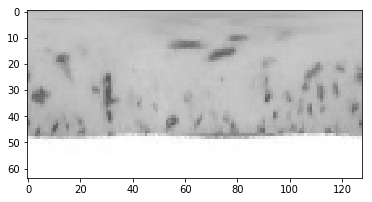

In [10]:
# Create an Sample image generator and get sample images to use throughout all the training for visualization


# Create callback function to use later.
sample_datagen = ImageDataGenerator(rescale=1. / 255)

sample_generator = sample_datagen.flow_from_directory(
        image_dir_samples,
        target_size=target_image_size,
        batch_size=16,
        class_mode='input',
        color_mode=color_mode)

next_batch = next(sample_generator)
sample_images = next_batch[0]
test_image=sample_images[1]
ti = test_image

#
display_image(test_image)


## Define Model for Training - Architecture

In [11]:
def define_model():
    
    
    #Input
    input_img = Input(shape=target_image_size_3D, name='input')  # adapt this if using `channels_first` image data format
    
     # Layer 10
    x = Conv2D(16, (5, 5), activation='relu', padding='same', strides=(2,2))(input_img)
#    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2,2))(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
    
#    # Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
#    
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)

    # Layer 30

#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    # Uplayer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 30
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)


#    #Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
#    
#    x = Conv2D(32, (3, 3), activation='relu')(x)
#    #x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
    
    # Uplayer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 10
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Output
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoded')(x)


    autoencoder = Model(input_img, outputs=decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    print(autoencoder.outputs)
        
    return autoencoder
    

In [72]:
# Create callback to write sample images to disk
class ProgressCallback(callbacks.Callback):
    
    def __init__(self, sample_image):
        self.sample_image = sample_image
        self.image4d = self.sample_image[None,:] # predict needs a batch of images (shape=4). This adds a dimension  
        
    def on_epoch_end(self, epoch, logs={}):
        
        processed_images = self.model.predict(x=[self.image4d],batch_size=1)
         
        # plot the image and save it
        f = plt.figure()
        f.add_subplot(1, 2, 1)  # this line outputs images side-by-side
        sim = get_image(self.sample_image)
        plt.imshow(sim)
        f.add_subplot(1, 2, 2)  # this line outputs images side-by-side
        pim = get_image(processed_images[0])
        plt.imshow(pim)
        plt.suptitle('Epoch ' + str(epoch))
        filename = 'epoch-' + str(epoch) + '.png'
        plt.savefig(filename)
        plt.close()
        #plt.show()


In [13]:
# Train the model
def train_model(model_to_train):
    progress = ProgressCallback(sample_image=sample_images[0])
    early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=training_early_stop_patience,
                              verbose=0, mode='auto')
    model_to_train.fit_generator(
        train_generator,
        steps_per_epoch=training_steps_per_epoch,
        epochs=training_number_of_epoch,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False),progress,early_stop])
    
    model_to_train.save(model_name + '.h5')
    
    return model_to_train

In [14]:
# Train the model
x = define_model()

[<tf.Tensor 'decoded/Sigmoid:0' shape=(?, 64, 128, 1) dtype=float32>]


In [73]:
print(x.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 128, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 16)        416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 32, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 32, 128)       36992     
_________________________________________________________________
encoder (MaxPooling2D)       (None, 8, 16, 128)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 16, 128)        147584    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 32, 128)       0         
__________

In [16]:
# Show encoder output size (before global pooling)
e = x.get_layer('encoder')
e.output

<tf.Tensor 'encoder/MaxPool:0' shape=(?, 8, 16, 128) dtype=float32>

In [76]:
#autoencoder = x
autoencoder = train_model(autoencoder)

Epoch 1/5
200/200 [==============================] - 85s 427ms/step - loss: 0.4880 - val_loss: 0.4639
Epoch 2/5
200/200 [==============================] - 86s 430ms/step - loss: 0.4881 - val_loss: 0.4638
Epoch 3/5
200/200 [==============================] - 85s 423ms/step - loss: 0.4879 - val_loss: 0.4640
Epoch 4/5
200/200 [==============================] - 84s 420ms/step - loss: 0.4879 - val_loss: 0.4639
Epoch 5/5
200/200 [==============================] - 83s 415ms/step - loss: 0.4880 - val_loss: 0.4638


In [77]:
#!pip3 install jupyter-tensorboard
for i in range(2):
    pass
    #autoencoder = train_model(x)

In [78]:
for i in range(50):
    #autoencoder = train_model(x)
    pass

In [79]:
# If all looks good, save the model
autoencoder.save(model_name_pretrained + '.h5')

# Test the model

In [23]:
# Import needed libraries
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator






In [24]:
# Load the model trained above
print('Loading model :')
t0 = time.time()
autoencoder = load_model(model_name_pretrained + '.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
t1 = time.time()
print('Model loaded in: ', t1-t0)


Loading model :
Model loaded in:  0.9467687606811523


# Convenience methods

In [25]:
class all_directory_images_generator:
    def __init__(self, sourcedir='data_with_rotations/test', batch_size=16, color_mode='grayscale', target_image_size=(100,100)):
        self.batch_size = batch_size
        self.sourcedir = sourcedir
        self.color_mode = color_mode
        self.target_image_size = target_image_size
        
        self.test_datagen = ImageDataGenerator(rescale=1. / 255)
        self.test_generator = self.test_datagen.flow_from_directory(
                sourcedir,
                target_size=target_image_size,
                batch_size=self.batch_size,
                class_mode='input',
                color_mode=self.color_mode,
                shuffle=False)
        
        self.n = self.test_generator.n
        self.filenames = self.test_generator.filenames   
        self.current_batch = 0
        self.max_batch = int(self.n / self.batch_size)
        
    def __iter__(self):
        return self

    def __next__(self):
        bi = self.test_generator.batch_index
        bs = self.test_generator.batch_size
        batch_file_names = self.test_generator.filenames[bi*bs:bi*bs+bs]
        return (next(self.test_generator), batch_file_names)



# Create encoder model

In [26]:
# Create a new model from the autoencoder, only up to the embedding layer
enc_model = Model(autoencoder.input, autoencoder.get_layer('encoder').output)

x1 = enc_model.get_layer('encoder').output
#x1 = GlobalMaxPooling2D(name='flat')(x1)
x1 = GlobalAveragePooling2D(name='flat')(x1)
encoder = Model(enc_model.input, x1)

# save the model to disk for reuse later
encoder.save(model_name_encoder + '.h5')
#encoder.save('encoder-32x64-4x8x128-AvgPool-prod.h5')


In [63]:
# Create dictionary with all filenames (keys) and predicted encodings (values)

image_dir_testing = 'data_with_many_rotations/train'
#image_dir_testing = 'data_projected/train'
#image_dir_testing = 'data_with_many_rotations/test'

image_encoding_dict = {}

test_images = all_directory_images_generator(batch_size=45, target_image_size=target_image_size, sourcedir=image_dir_testing)
bs = test_images.batch_size

for i in range(test_images.max_batch):
    images_both_x_and_y, names = next(test_images)
    images = images_both_x_and_y[0]
    encodings = encoder.predict(images,batch_size=bs)
    for j in range(bs):
        image_encoding_dict[names[j]]=encodings[j]
        


# Create dictionary with index integers (keys) and filenames (values)
#   This is needed later for Annoy, since it uses integers as item keys, and we have to map back to a filename
image_filename_dict = {}

i = 0
for key, value in image_encoding_dict.items():
    image_filename_dict[i]=key
    i = i+1



Found 8100 images belonging to 1 classes.


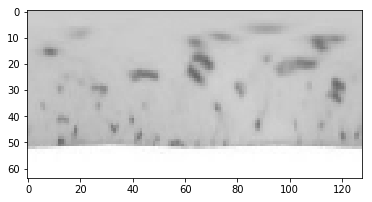

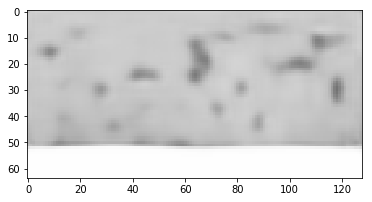

images/100_0.jpg


In [64]:
# Let's just view a few input images and output images from the autoencoder
#   This includes the decoder part of the autoencoder, so we'll still see an image

next_batch, next_filenames = next(test_images) # Use the test_images defined above
#next_batch = next(test_generator)
images = next_batch[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

recreated_pill = autoencoder.predict(x=images,batch_size=32)

plt.imshow(get_image(recreated_pill[0]))
plt.show()
print(next_filenames[0])



# Get a feel for the outputs

In [28]:
# Load a dataframe from the dictionary
import pandas as pd
df = pd.DataFrame.from_dict(image_encoding_dict, orient='index')

#df['filename'] = df.index
#df['image']= df['filename'].apply(lambda x: x.split('/')[-1])
#HOLY COW!  All of these are so close together. :-(  Can't differentiate one from another easily - Deeper network help?
#df.to_csv('96_images_32x64_AvgPool_4x8.csv')

#df

In [29]:
# Look at the simple statistics around the encodings
dfstat = df.describe()
dfstat

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,...,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,0.110669,0.157751,0.022162,0.000018,0.118882,0.117522,0.173365,0.095322,0.029871,0.075235,...,0.125714,0.076557,0.092160,0.069770,0.025052,0.272707,0.095370,0.000161,0.037957,0.056826
std,0.007941,0.013088,0.003643,0.000056,0.004518,0.006497,0.007722,0.005343,0.003470,0.006404,...,0.009534,0.005236,0.009065,0.006691,0.004126,0.009422,0.006811,0.000373,0.004305,0.004749
min,0.092274,0.121793,0.014398,0.000000,0.107826,0.097776,0.154215,0.082896,0.021457,0.058513,...,0.105092,0.063471,0.071516,0.058891,0.015410,0.246458,0.073433,0.000000,0.027329,0.042998
25%,0.105961,0.150873,0.019838,0.000000,0.116109,0.114409,0.168237,0.091846,0.027458,0.070633,...,0.118039,0.073063,0.084151,0.064315,0.023055,0.266337,0.090765,0.000000,0.034912,0.053503
50%,0.109647,0.159198,0.021881,0.000000,0.118558,0.117693,0.173249,0.094804,0.029332,0.074442,...,0.125099,0.076395,0.092830,0.069414,0.025634,0.273915,0.096735,0.000000,0.037818,0.056663
75%,0.118179,0.164532,0.025445,0.000000,0.121014,0.121698,0.179442,0.098992,0.032405,0.080215,...,0.133039,0.081132,0.099956,0.073881,0.027934,0.279368,0.100373,0.000105,0.040953,0.060350
max,0.127484,0.189541,0.031535,0.000542,0.131702,0.135334,0.192607,0.108652,0.039240,0.087202,...,0.145627,0.087250,0.108553,0.084479,0.033406,0.294299,0.107638,0.001916,0.048815,0.069147


In [31]:
# See how they all cluster
from sklearn.cluster import KMeans

number_of_clusters=24
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(df)
print(km.labels_)

[9 9 9 ... 8 8 8]


In [32]:
# Convert results to a dataframe - note that to get the index / filename, I had to include the first column
results = pd.DataFrame({
    'ignore': df[0],
    'category': km.labels_
})
results.groupby('category').count()

,ignore
category,
0,45
1,45
2,45
3,45
4,45
5,45
6,45
7,45
8,45


In [180]:
#show the distance between images
#  should be small distances between rotated images - ideally zero
from scipy.spatial.distance import squareform, pdist
distdf = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
#distdf

In [181]:
# Show the covariance between the columns - not useful since it's unscaled. :-(
#covdf = df.cov()*10000 #, columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
#covdf

In [182]:
# Show the correlation between the columns (which represent a global pool from the encoder convolutions)
#   Correlation appears high, likely could do some PCA, but seems like tuning the autoencoder should be able to do that
corrdf = df.corr() #, columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
#corrdf

# Annoy for nearest neighbor search

In [57]:
# Create Annoy database file

from annoy import AnnoyIndex

embedding_vector_size = 128

f = embedding_vector_size      # Length of item vector that will be indexed
t = AnnoyIndex(f)  

for i in range(len(image_encoding_dict)):
    t.add_item(i,image_encoding_dict[image_filename_dict[i]])
    
t.build(25) # 25 trees - need to explore what is a good setting here
t.save(model_name + '.ann') # Save the model
t.save('encoder-64x128-8x16x128-AvgPool-prod-core.ann')

import pickle
file = open(model_name + '.pkl',"wb")
pickle.dump(image_filename_dict,file)
file.close()


In [58]:
# Open Annoy database file get example

sample_item_index = 0
nn_count = 5 # count of nearest neighbors to find

u = AnnoyIndex(f)
u.load(model_name + '.ann') # super fast, will just mmap the file

nn = u.get_nns_by_item(sample_item_index, nn_count) # will find the 5 nearest neighbors

for i in nn:
    distance = u.get_distance(sample_item_index, i)
    print(str(i) + ' - ' + image_filename_dict[i] + ' : ' + str(distance))
    



0 - images/1.jpg : 0.0
89 - images/18.jpg : 0.026587802916765213
51 - images/145.jpg : 0.03733743354678154
137 - images/60.jpg : 0.0419006310403347
93 - images/20.jpg : 0.04448811709880829


In [60]:
# Calculate some metric of goodness. Basically, see how many pills clump when rotated. 
#   In other words, the 4 closest pills to pill 219 should be itself plus the three rotations of it.

number_rotations = 1 # the total images for each pill
top_n = 1 # only get the top n images for comparison - not looking for 100% perfection, just in top n results

same_images={key: [key+i for i in range(number_rotations)] for key in image_filename_dict if key % number_rotations == 0}
same_images # key is first value, value is list with all the similar images

incorrect_pills = 0 #sum of count of pills
incorrect_pill_images = 0 # sum of ALL the mistakes

incorrect_pills_top_n = 0
incorrect_pill_images_top_n = 0

total_pills = len(image_filename_dict)/number_rotations
total_pill_images = len(image_filename_dict)

for key, value in same_images.items():
    top_matches = u.get_nns_by_item(key, number_rotations)
    mismatches = set(value)-set(top_matches)
    if len(mismatches) != 0:
        incorrect_pills += 1
        incorrect_pill_images += len(mismatches)
    
    top_n_mismatches = set(top_matches[0:top_n])-set(value)
    if len(top_n_mismatches) != 0:
        incorrect_pills_top_n += 1
        incorrect_pill_images_top_n += len(top_n_mismatches)  
        
        #print(image_filename_dict[top_n_mismatches.pop()])
        #print(f'Image to match is {image_filename_dict[value[0]]}')
        for i in top_matches:
            print(image_filename_dict[i])
        

print(f'Number of pills with any errors:  {incorrect_pills} out of {total_pills} pills')
print(f"Number of pill image errors:      {incorrect_pill_images} out of {total_pill_images} images")

print(f'Number of pills with errors in {top_n}:       {incorrect_pills_top_n} out of {total_pills} pills')
print(f"Number of pill image errors in top {top_n}:   {incorrect_pill_images_top_n} out of {total_pill_images} images")



Number of pills with any errors:  0 out of 180.0 pills
Number of pill image errors:      0 out of 180 images
Number of pills with errors in 1:       0 out of 180.0 pills
Number of pill image errors in top 1:   0 out of 180 images


## Validate rotations with Annoy db with only unrotated values


In [65]:
# Open Annoy database file to get database

sample_item_index = 0
nn_count = 5 # count of nearest neighbors to find

u = AnnoyIndex(f)

# Load the right encoder - hard coded right now
u.load('encoder-64x128-8x16x128-AvgPool-prod-core.ann')


nn = u.get_nns_by_item(sample_item_index, nn_count) # will find the 5 nearest neighbors

for i in nn:
    distance = u.get_distance(sample_item_index, i)
    print(str(i) + ' - ' + image_filename_dict[i] + ' : ' + str(distance))
    



0 - images/100_0.jpg : 0.0
89 - images/101_95.jpg : 0.026587802916765213
51 - images/101_13.jpg : 0.03733743354678154
137 - images/103_105.jpg : 0.0419006310403347
93 - images/102_118.jpg : 0.04448811709880829


In [67]:
# Go up and run the encoder to get the needed dictionaries for all the rotated images. Will need to rerun stuff.

print(len(image_encoding_dict))
print(len(image_filename_dict))


import pickle
file = open(model_name + '.pkl',"rb")
annoy_image_encoding_dict = pickle.load(file)
file.close()

print(len(annoy_image_encoding_dict))

matches = {}

# iterate through image_encoding_dict and find the nearest vector in the 
for key, encoding in image_encoding_dict.items():
    #print(encoding)
    closest_in_annoy = u.get_nns_by_vector(encoding, 1)
    test_img_name = key
    closest_annoy_img_name = annoy_image_encoding_dict[closest_in_annoy[0]]
    matches[test_img_name] = closest_annoy_img_name
    #print(f'{test_img_name} is closest to {closest_annoy_img_name}')

#matches


8100
8100
180


In [68]:
# Turn into pandas dataframe for easier manipulation
df = pd.DataFrame.from_dict(matches, orient='index', columns=['predicted_image_path'])
df['input_image_path'] = df.index
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df['predicted_image'] = df['predicted_image_path'].apply(lambda x: x.split('/')[1])
df['predicted_image'] = df['predicted_image'].apply(lambda x: x.split('.')[0])

df['input_image'] = df['input_image_path'].apply(lambda x: x.split('/')[1])
df['input_image'] = df['input_image'].apply(lambda x: x.split('.')[0])
df['input_image_base'] = df['input_image'].apply(lambda x: x.split('_')[0])
df['input_image_rotation'] = df['input_image'].apply(lambda x: x.split('_')[1])


errors = df[df['predicted_image'] != df['input_image_base']]
len(errors)

12

In [70]:
errors

,predicted_image_path,input_image_path,predicted_image,input_image,input_image_base,input_image_rotation
116,images/104.jpg,images/102_30.jpg,104,102_30,102,30
548,images/128.jpg,images/111_16.jpg,128,111_16,111,16
581,images/167.jpg,images/111_77.jpg,167,111_77,111,77
582,images/128.jpg,images/111_83.jpg,128,111_83,111,83
1147,images/21.jpg,images/123_251.jpg,21,123_251,123,251
1150,images/21.jpg,images/123_263.jpg,21,123_263,123,263
2010,images/179.jpg,images/140_347.jpg,179,140_347,140,347
3695,images/5.jpg,images/175_144.jpg,5,175_144,175,144
3726,images/131.jpg,images/175_346.jpg,131,175_346,175,346
6614,images/157.jpg,images/6_99.jpg,157,6_99,6,99
